In [20]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.tree import plot_tree
# from sklearn.model_selection import train_test_split
# from sksurv.ensemble import RandomSurvivalForest
# from sksurv.linear_model import CoxPHSurvivalAnalysis
# from sksurv.metrics import concordance_index_censored , concordance_index_ipcw
# from sklearn.impute import SimpleImputer
# from sksurv.util import Surv
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, cohen_kappa_score


class
1    0.511524
0    0.488476
Name: proportion, dtype: float64


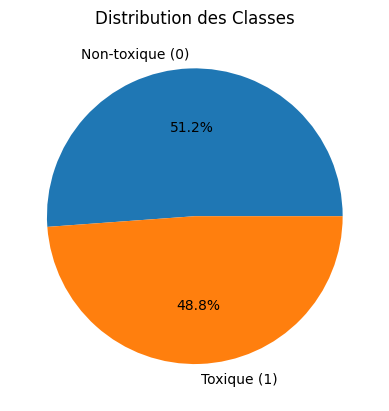

In [21]:
train = pd.read_csv('train.csv')
print(train['class'].value_counts(normalize=True))
plt.pie(train['class'].value_counts(), labels=['Non-toxique (0)', 'Toxique (1)'], autopct='%1.1f%%')
plt.title('Distribution des Classes')
plt.show()

In [22]:
# Corrélation des 199 descripteurs avec la target => Identifier les descripteurs les plus informatifs pour la prédiction.
corr_matrix = train.iloc[:, 1:200].corrwith(train['class']).sort_values(ascending=False)
print("Top 10 descripteurs corrélés :\n", corr_matrix.head(10))


# Sparsité des empreintes
ecfc_nonzero = train.filter(like='ecfc').astype(bool).sum(axis=1).mean()
fcfc_nonzero = train.filter(like='fcfc').astype(bool).sum(axis=1).mean()
print(f"Bits actifs en moyenne : ECFC={ecfc_nonzero:.1f}, FCFC={fcfc_nonzero:.1f}")

Top 10 descripteurs corrélés :
 MolLogP                   0.280784
EState_VSA4               0.198871
EState_VSA8               0.180896
VSA_EState6               0.177124
PEOE_VSA6                 0.175702
PEOE_VSA7                 0.165591
MinAbsEStateIndex         0.160275
VSA_EState5               0.157600
fr_benzene                0.154455
NumAromaticCarbocycles    0.153473
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Bits actifs en moyenne : ECFC=55.9, FCFC=45.0


### Top 10 Descripteurs Corrélés: 
- MolLogP (0.28) : La lipophilie est un marqueur connu de toxicité hERG (les molécules trop lipophiles bloquent plus souvent le canal).

- EState_VSA4/8, VSA_EState : Liés aux surfaces polaires et états électroniques → reflètent des interactions potentielles avec le canal hERG.

- fr_benzene/NumAromaticCarbocycles : Cycles aromatiques souvent présents dans les inhibiteurs hERG.

Action :

- Feature Importance : Conserver ces descripteurs dans tous les modèles.

- Interprétabilité : Utiliser SHAP pour expliquer leur impact (ex : shap.force_plot).


### Sparsité des Empreintes

ECFC (55.9 bits actifs/2048) et FCFC (45.0/2048) : Très sparse (~2.7% et ~2.2% de bits actifs).

Problème : Risque de surapprentissage si utilisé bruts.

Solutions :

- Réduction de dimension : PCA/UMAP (comme proposé) ou sélection de bits (ex : variance non nulle).

- Alternative : Utiliser des autoencodeurs pour compresser les empreintes en 50-100 dimensions.

In [23]:
# Création de nouvelles features interactives
train['LogP_aromatic'] = train['MolLogP'] * train['NumAromaticCarbocycles']
train['TPSA_ratio'] = train['TPSA'] / (train['MolLogP'] + 1e-6)

# Standardisation
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train[['MolLogP', 'TPSA']] = scaler.fit_transform(train[['MolLogP', 'TPSA']])

In [24]:
# Création de nouvelles features interactives
train['LogP_aromatic'] = train['MolLogP'] * train['NumAromaticCarbocycles']
train['TPSA_ratio'] = train['TPSA'] / (train['MolLogP'] + 1e-6)

# Standardisation
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train[['MolLogP', 'TPSA']] = scaler.fit_transform(train[['MolLogP', 'TPSA']])

In [25]:
from sklearn.decomposition import TruncatedSVD  # Mieux que PCA pour données sparse

# Réduction ECFC
ecfc_data = train.filter(like='ecfc')
svd_ecfc = TruncatedSVD(n_components=50, random_state=42)
ecfc_reduced = svd_ecfc.fit_transform(ecfc_data)

# Réduction FCFC
fcfc_data = train.filter(like='fcfc')
svd_fcfc = TruncatedSVD(n_components=50, random_state=42)
fcfc_reduced = svd_fcfc.fit_transform(fcfc_data)

# Conversion en DataFrame
ecfc_df = pd.DataFrame(ecfc_reduced, columns=[f'ECFC_SVD_{i}' for i in range(50)])
fcfc_df = pd.DataFrame(fcfc_reduced, columns=[f'FCFC_SVD_{i}' for i in range(50)])

# Fusion
train_reduced = pd.concat([train.drop(columns=ecfc_data.columns), train.drop(columns=fcfc_data.columns), ecfc_df, fcfc_df], axis=1)

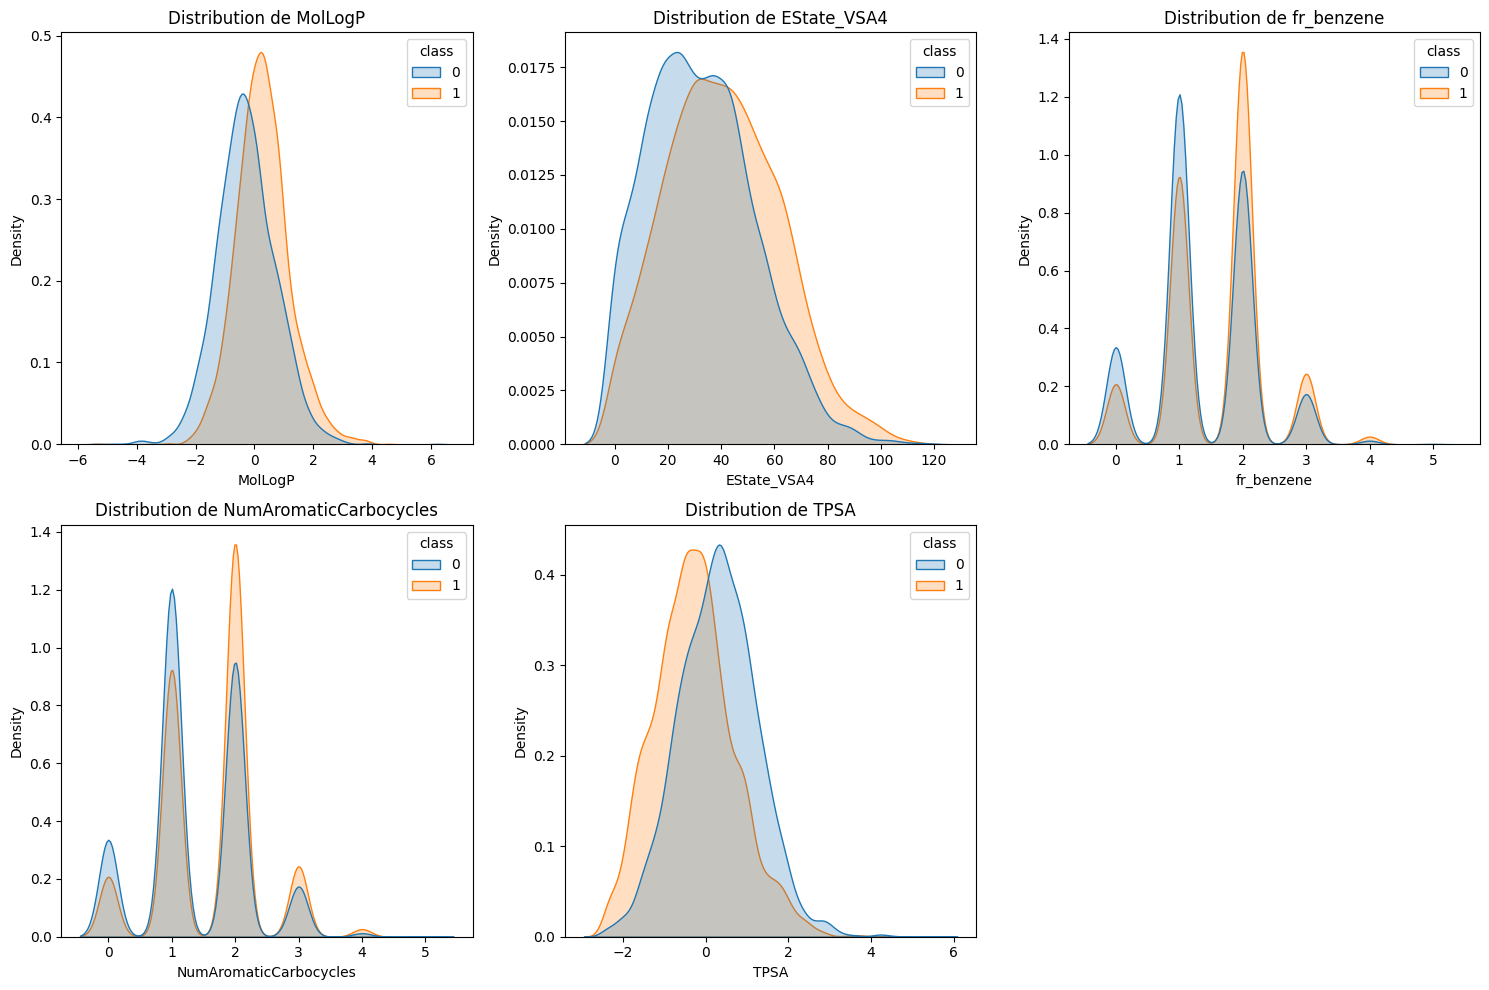

In [26]:
# Top 5 descripteurs corrélés
top_features = ['MolLogP', 'EState_VSA4', 'fr_benzene', 'NumAromaticCarbocycles', 'TPSA']
plt.figure(figsize=(15, 10))
for i, feat in enumerate(top_features):
    plt.subplot(2, 3, i+1)
    sns.kdeplot(data=train, x=feat, hue='class', fill=True, common_norm=False)
    plt.title(f'Distribution de {feat}')
plt.tight_layout()
plt.show()

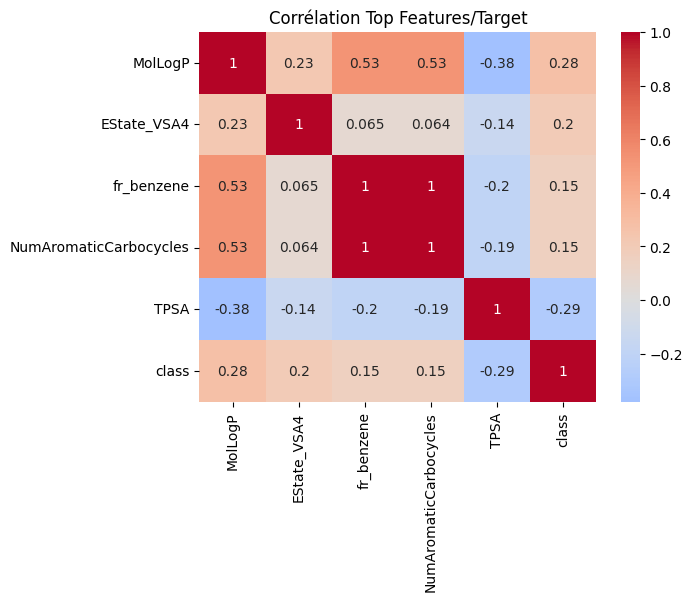

In [27]:
# Corrélation entre top features + target
corr_matrix = train[top_features + ['class']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Corrélation Top Features/Target')
plt.show()

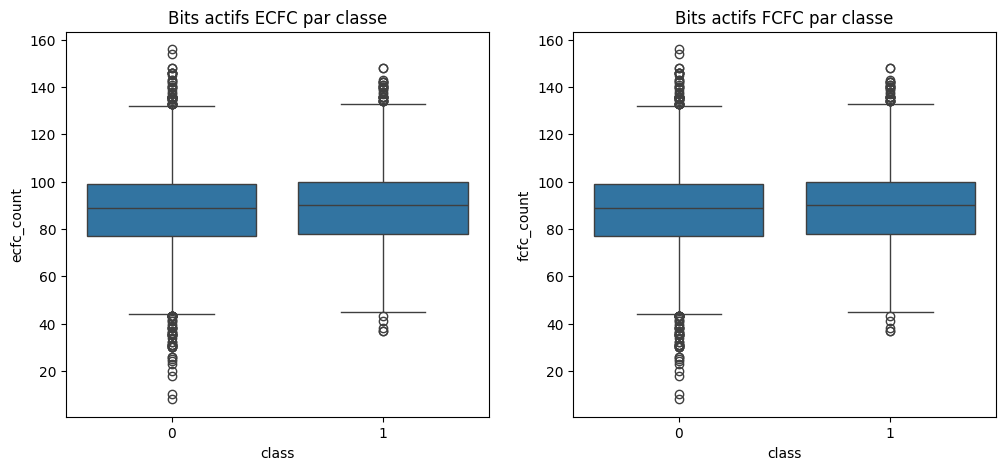

In [28]:
# Nombre de bits actifs par molécule
train['ecfc_count'] = train.filter(like='ecfc').sum(axis=1)
train['fcfc_count'] = train.filter(like='fcfc').sum(axis=1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(data=train, x='class', y='ecfc_count')
plt.title('Bits actifs ECFC par classe')

plt.subplot(1, 2, 2)
sns.boxplot(data=train, x='class', y='fcfc_count')
plt.title('Bits actifs FCFC par classe')
plt.show()

=> Si les toxiques ont plus de bits actifs, cela indique une complexité structurale accrue

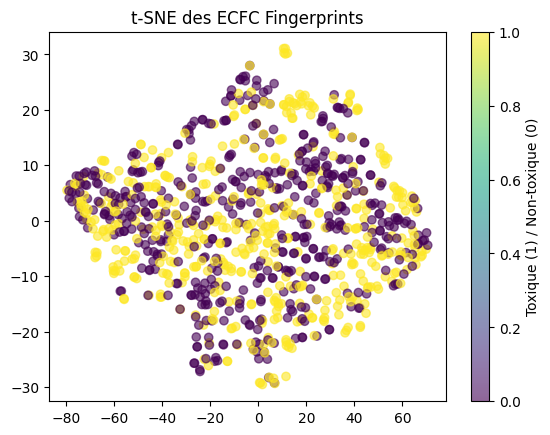

In [29]:
from sklearn.manifold import TSNE

# Échantillonnage pour accélérer le calcul
sample_idx = np.random.choice(train.index, 1000, replace=False)
X_tsne = TSNE(n_components=2, perplexity=30).fit_transform(train.loc[sample_idx].filter(like='ecfc'))

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=train.loc[sample_idx, 'class'], alpha=0.6)
plt.title('t-SNE des ECFC Fingerprints')
plt.colorbar(label='Toxique (1) / Non-toxique (0)')
plt.show()

In [30]:
# Ajout des coordonnées t-SNE comme features
train['tsne_x'] = X_tsne[:, 0]
train['tsne_y'] = X_tsne[:, 1]

ValueError: Length of values (1000) does not match length of index (9415)